In [1]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

In [2]:
# !pip install import-ipynb

In [3]:
import import_ipynb

In [4]:
# %cd /content/drive/MyDrive/A62_projet_synthese_feature/feature-colab-from-git/notebook

In [5]:
%run iteration_0_imports.py

In [6]:
%run iteration_0_parameters.py

In [7]:
import iteration_0_utils as utils

importing Jupyter notebook from iteration_0_utils.ipynb


In [8]:
%whos

Variable                          Type        Data/Info
-------------------------------------------------------
HEALTHY                           str         H
IMG_IN_COLOR                      int         1
IMG_SIZE                          int         64
Image                             module      <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
NBR_SAMPLE                        int         20000
PATH_DATA                         str         ../data
PATH_DATA_EDA                     str         ../data/eda
PATH_DATA_LIST                    str         ../data/list
PATH_DATA_SAMPLE                  str         ../data/sample
PATH_MODEL                        str         ../model
PATH_ROOT                         str         ..
PATH_SOURCE_IMG                   str         ../cell_images
RandomForestClassifier            ABCMeta     <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SICK                              str         S
classification_report             function

In [9]:
DATE_TIME = "2021-11-18_20-39-00"

"""
PATH_SAMPLE = "data/sample"
HEALTHY = "H"
SICK = "S"
IMG_SIZE = 400
"""

'\nPATH_SAMPLE = "data/sample"\nHEALTHY = "H"\nSICK = "S"\nIMG_SIZE = 400\n'

# Modele

In [10]:
PATH_DATA_SAMPLE

'../data/sample'

In [11]:
NBR_SAMPLE

20000

In [12]:
DATE_TIME

'2021-11-18_20-39-00'

In [13]:
IMG_SIZE

64

## Read X y

In [14]:
X_train = utils.pickle_read(PATH_MODEL + "/" + "X_train.pklz")
X_test = utils.pickle_read(PATH_MODEL + "/" + "X_test.pklz")
y_train = utils.pickle_read(PATH_MODEL + "/" + "y_train.pklz")
y_test = utils.pickle_read(PATH_MODEL + "/" + "y_test.pklz")

## Random forest

In [15]:
model_rf = RandomForestClassifier(random_state = 0)

In [16]:
# fit model
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [17]:
utils.pickle_save(model_rf, PATH_MODEL + "/model_rf_rm_2021-01-16_14h28.pklz")

In [18]:
# Assert False

In [19]:
y_pred = model_rf.predict(X_test)

## Obtenir les métriques

In [20]:
# create dataframe metrics
df_metrics = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred), columns = ["H", "S"], 
         index=["Precion", "Recall", "F1", "Support"])
# add average column    
df_metrics["average_macro"] = precision_recall_fscore_support(y_test, y_pred, average = "macro")
df_metrics = df_metrics.replace(np.nan, -999)
sr_metrics = df_metrics.stack(dropna=False)

df_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ["cm_H", "cm_S"], index = ["cm_H", "cm_S"])
sr_confusion_matrix = df_confusion_matrix.stack()
sr_metrics = pd.concat([sr_metrics, sr_confusion_matrix])

In [21]:
df_metrics

,H,S,average_macro
Precion,0.784314,0.781203,0.782759
Recall,0.780000,0.785500,0.782750
F1,0.782151,0.783346,0.782748
Support,2000.000000,2000.000000,-999.000000


In [22]:
df_confusion_matrix

,cm_H,cm_S
cm_H,1560,440
cm_S,429,1571


## Tracker les métriques

* **N.B**:
    * **Dans un terminal lancer la commande : mlflow ui**

In [23]:
mlflow.set_experiment(experiment_name='Projet_A62')
mlflow.set_tracking_uri("http://localhost:5000")

In [25]:
with mlflow.start_run(nested=True) as run:
    for idx, val in enumerate(sr_metrics):
        mlflow.log_metric("_".join(sr_metrics.index[idx]) ,val)
    
    mlflow.sklearn.log_model(model_rf, "model")
    mlflow.set_tag("model_rf", str(model_rf))

In [26]:
# Sauvegarder le modèle
os.makedirs(PATH_MODEL, exist_ok=True)
utils.pickle_save(model_rf, PATH_MODEL + "/" + "model_rf.pklz")

### Courbe d'apprentissage

In [27]:
def spot_overfit_needed_data(model, X_train, y_train, cv = 5, scoring= "f1_macro"):

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv = cv, 
                                               train_sizes =np.linspace(0.1, 1, 10),
                                                scoring = scoring)

    plt.figure(figsize=(12,8))
    plt.grid()
    axes = plt.gca()
    axes.set_ylim([0.5,1.05])
    plt.plot(N, train_score.mean(axis = 1), "o-", label = "train_score")
    plt.plot(N, val_score.mean(axis = 1)  , "o-", label = "validation_score")
    plt.legend()
    plt.show()


# Tests pour voir pourquoi le 100% train_score

In [28]:
X_train = utils.pickle_read(PATH_MODEL + "/" + "X_train.pklz")
X_test = utils.pickle_read(PATH_MODEL + "/" + "X_test.pklz")
y_train = utils.pickle_read(PATH_MODEL + "/" + "y_train.pklz")
y_test = utils.pickle_read(PATH_MODEL + "/" + "y_test.pklz")

## tester les hyper-parametres

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [30]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

In [31]:
train_results = []
test_results = []
for estimator in tqdm(n_estimators):
    model_rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    # entrainer le modele
    model_rf.fit(X_train, y_train)
    
    # train set
    # faire les prediciton des probas
    rf_probas_train = model_rf.predict_proba(X_train)[:,1]
    train_results.append(roc_auc_score(y_train, rf_probas_train))
    
    # test set
    # faire les prediciton des probas
    rf_probas_test  = model_rf.predict_proba(X_test)[:,1]    
    test_results.append(roc_auc_score(y_test, rf_probas_test))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:41<00:00, 11.32s/it]


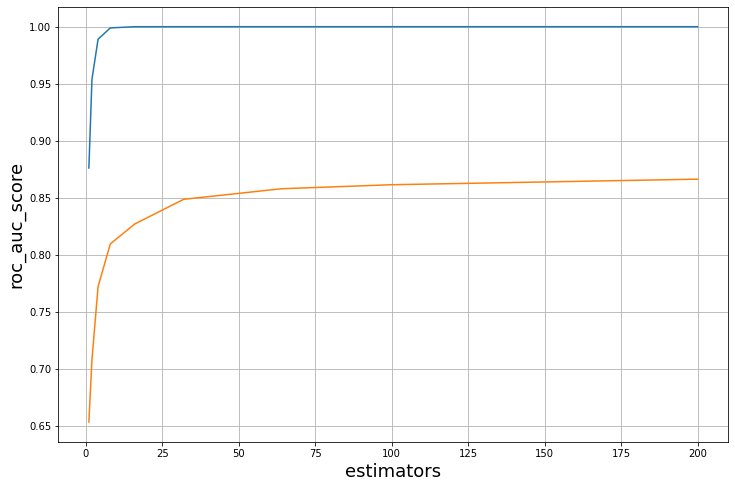

In [32]:
plt.figure(figsize=(12,8))
plt.grid()
plt.plot(n_estimators, train_results, label = "train")
plt.plot(n_estimators, test_results,  label = "test")
plt.xlabel('estimators', fontsize=18)
plt.ylabel('roc_auc_score', fontsize=18)
plt.show()

In [33]:
max_depths = np.linspace(1, 32, 32, endpoint=True)

In [35]:
max_depths

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32.])

In [36]:
train_results = []
test_results = []
for max_depth in tqdm(max_depths):
    model_rf = RandomForestClassifier(max_depth = max_depth, n_jobs=-1)
    
    # entrainer le modele
    model_rf.fit(X_train, y_train)
    
    # train set
    # faire les prediciton des probas
    rf_probas_train = model_rf.predict_proba(X_train)[:,1]
    train_results.append(roc_auc_score(y_train, rf_probas_train))
    
    # test set
    # faire les prediciton des probas
    rf_probas_test = model_rf.predict_proba(X_test)[:,1]
    test_results.append(roc_auc_score(y_test, rf_probas_test))

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [06:59<00:00, 13.11s/it]


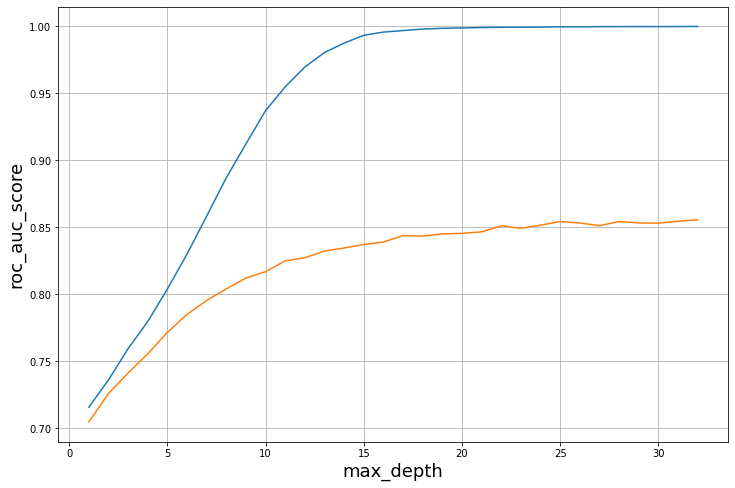

In [37]:
plt.figure(figsize=(12,8))
plt.grid()
plt.plot(max_depths, train_results, label = "train")
plt.plot(max_depths, test_results,  label = "test")
plt.xlabel('max_depth', fontsize=18)
plt.ylabel('roc_auc_score', fontsize=18)
plt.show()

In [38]:
model_rf05 = RandomForestClassifier(random_state=0, max_depth=5)
model_rf15 = RandomForestClassifier(random_state=0, max_depth=15)
model_rf32 = RandomForestClassifier(random_state=0, max_depth=32)
model_rf05.fit(X_train, y_train)
model_rf15.fit(X_train, y_train)
model_rf32.fit(X_train, y_train)

RandomForestClassifier(max_depth=32, random_state=0)

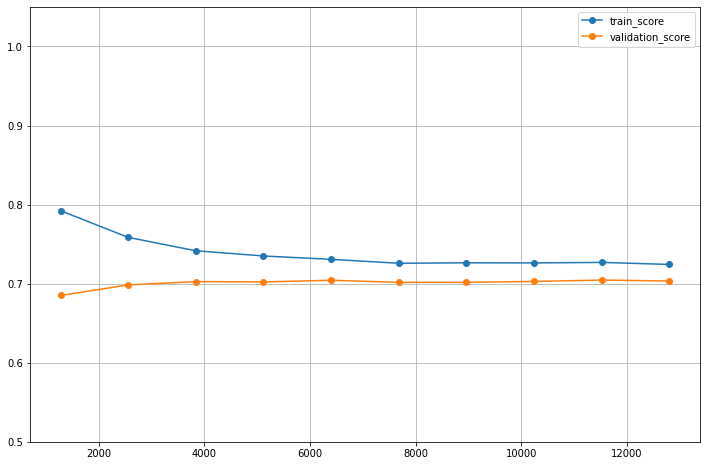

In [39]:
spot_overfit_needed_data(model_rf05, X_train, y_train)

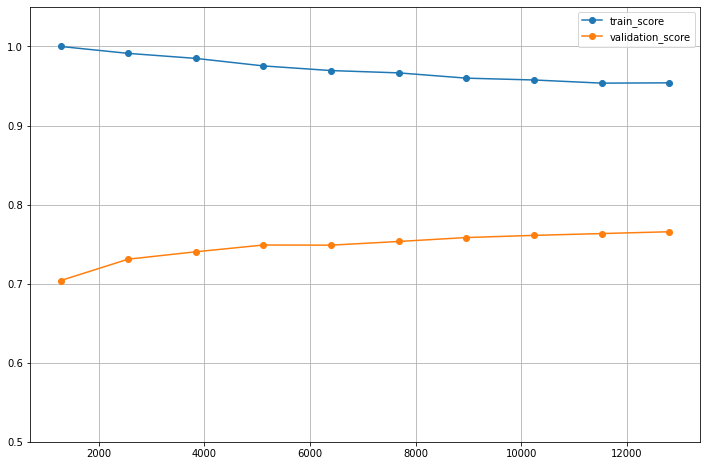

In [40]:
spot_overfit_needed_data(model_rf15, X_train, y_train)

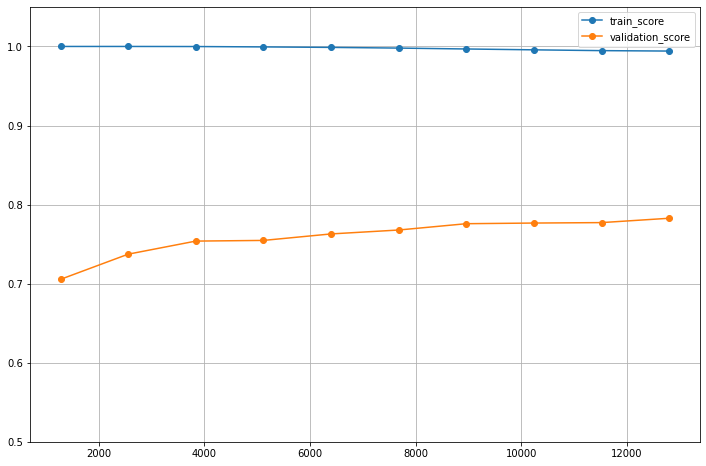

In [41]:
spot_overfit_needed_data(model_rf32, X_train, y_train)

In [42]:
model_org = RandomForestClassifier(random_state = 0)
model_org.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

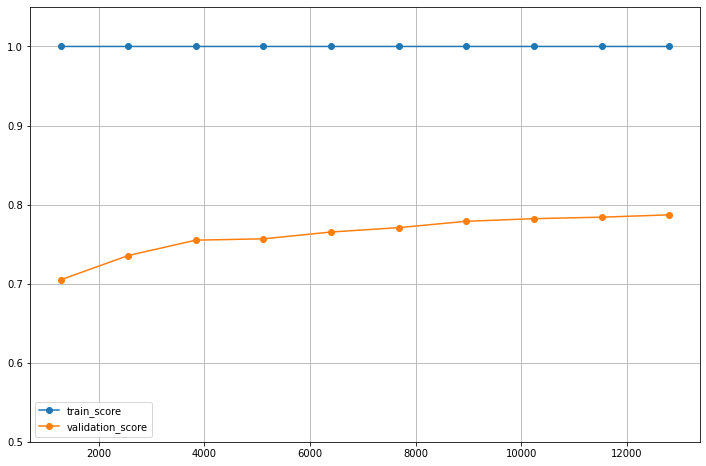

In [43]:
spot_overfit_needed_data(model_org, X_train, y_train)

## Knn

In [44]:
from sklearn.neighbors import KNeighborsClassifier

In [45]:
knn = KNeighborsClassifier()

In [46]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

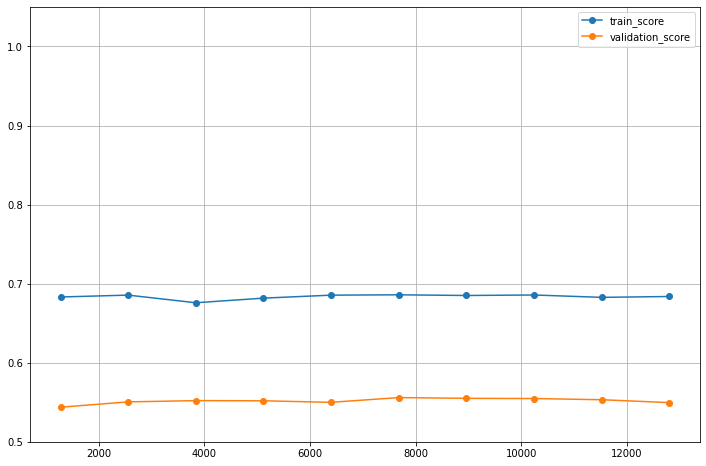

In [47]:
spot_overfit_needed_data(knn, X_train, y_train)